In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    compress_repeated_epochs,
    add_new_deep_sup,
    custom_plots
)
from ripple_heterogeneity.place_cells import place_cells_run, fields, place_cell_plots, maps
import statistics
import nelpy as nel
from scipy.ndimage import gaussian_filter
from scipy.ndimage import rotate
import pickle
import glob
from matplotlib.ticker import AutoMinorLocator

functions.set_plotting_defaults()

%config InlineBackend.figure_format = 'retina'

fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## find sessions with many mazes

In [9]:
df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')

epoch_df = pd.DataFrame()
for basepath in df.basepath.unique():
    epoch_df_temp = loading.load_epoch(basepath)
    epoch_df_temp["basepath"] = basepath
    epoch_df_temp["animal"] = loading.get_animal_id(basepath)
    epoch_df = pd.concat([epoch_df,epoch_df_temp],ignore_index=True)

In [10]:
multi_epoch_sessions = epoch_df.query("environment!='sleep'").groupby("basepath").apply(
    lambda x: pd.Series({"n_env": x.environment.nunique()})
).reset_index().sort_values("n_env", ascending=False).query("n_env>2")


In [11]:
import logging
logging.getLogger().setLevel(logging.ERROR)
# Turn interactive plotting off
plt.ioff()

def load_data(basepath):

    # get spikes
    st,cm = loading.load_spikes(basepath,putativeCellType="Pyr",brainRegion="CA1")
    cm = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cm)

    # get position
    position_df = loading.load_animal_behavior(basepath)
    position_df_no_nan = position_df.query("not x.isnull() & not y.isnull()")
    pos = nel.PositionArray(data=np.array([position_df_no_nan[["x","y"]]]).T,timestamps=position_df_no_nan.time.values)

    # load epochs
    epoch_df = loading.load_epoch(basepath)
    epochs = nel.EpochArray(np.array([epoch_df.startTime,epoch_df.stopTime]).T)
    return st,cm,epoch_df,epochs,pos

def plot_heatmaps(cm,epoch_df,epochs,UID):
    index = epoch_df.query("environment != 'sleep'").index

    fig, axs = plt.subplots(1,len(index),figsize=functions.set_size("thesis", fraction=2, subplots=(2, len(index))),edgecolor=None)
    plt.subplots_adjust(wspace=0, hspace=0)

    uid_idx = np.where((cm.UID == UID).values)[0][0]
    for ind_i, ind in enumerate(index):
        try:
            tc = maps.SpatialMap(pos[epochs[ind]],st[epochs[ind]],dim=2,tuning_curve_sigma=5)
        except:
            axs[ind_i].axis("equal")
            axs[ind_i].axis("off")
            continue
        ratemap_ = tc.tc.ratemap[uid_idx,:,:].copy()
        ratemap_[tc.tc.occupancy == 0] = np.nan
        sns.heatmap(ratemap_,cmap="magma",cbar=False,ax=axs[ind_i],vmin=0, vmax=2,rasterized=True)
        axs[ind_i].axis("equal")
        axs[ind_i].axis("off")
    return fig

save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels\multi_env_place_cells_v2"
for basepath in multi_epoch_sessions.basepath.unique():
    st,cm,epoch_df,epochs,pos = load_data(basepath)  
    custom_name = basepath.replace(os.sep, "_").replace(":", "_")
    
    for uid,deepSuperficial in zip(cm.UID,cm.deepSuperficial):        
        fig = plot_heatmaps(cm,epoch_df,epochs,uid)
        plt.savefig(
            os.path.join(save_path,custom_name + "_uid_" + str(uid) + "_" + deepSuperficial+ ".jpeg"),
            dpi=300,
            bbox_inches="tight",
        )
        plt.close(fig)

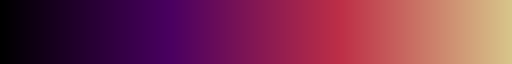

In [20]:
# import numpy as np
# import matplotlib.pyplot as plt
import matplotlib.colors

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#000000","#4a0061","#be2f47","#d8c58a"])

cmap

sup ex: Z__Data_Kenji_ec013.480_509 uid 40,22

deep: uid 23

In [ ]:
# Z__Data_Kenji_ec013.944_95816

In [3]:
# basepath = "Z:\\Data\\Kenji\\ec013.393_418"
# basepath = "Z:\\Data\\Kenji\\ec013.944_958"
basepath = "Z:\\Data\\Kenji\\ec013.634_653"

# get spikes
st,cm = loading.load_spikes(basepath,putativeCellType="Pyr",brainRegion="CA1")

# get position
position_df = loading.load_animal_behavior(basepath)
position_df_no_nan = position_df.query("not x.isnull() & not y.isnull()")
pos = nel.PositionArray(data=np.array([position_df_no_nan[["x","y"]]]).T,timestamps=position_df_no_nan.time.values)

# load epochs
epoch_df = loading.load_epoch(basepath)
epochs = nel.EpochArray(np.array([epoch_df.startTime,epoch_df.stopTime]).T)

In [4]:
cm = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cm)

In [6]:
cm.query("deepSuperficial == 'Superficial'").UID

60    61
65    66
81    82
Name: UID, dtype: uint8

In [7]:
cm.query("deepSuperficial == 'Deep'").UID


49      50
50      51
67      68
71      72
72      73
84      85
101    102
103    104
104    105
Name: UID, dtype: uint8

In [ ]:
import logging
logging.getLogger().setLevel(logging.ERROR)
# import matplotlib.colors


def plot_heatmaps(cm,epoch_df,epochs,UID):
    # cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#000000","#4a0061","#be2f47","#d8c58a"])

    index = epoch_df.query("environment != 'sleep'").index

    fig, axs = plt.subplots(1,len(index),figsize=functions.set_size("thesis", fraction=2, subplots=(2, len(index))),edgecolor=None)
    plt.subplots_adjust(wspace=0, hspace=0)

    uid_idx = np.where((cm.UID == UID).values)[0][0]
    for ind_i, ind in enumerate(index):
        try:
            tc = maps.SpatialMap(pos[epochs[ind]],st[epochs[ind]],dim=2,tuning_curve_sigma=5)
        except:
            axs[ind_i].axis("equal")
            axs[ind_i].axis("off")
            continue
        ratemap_ = tc.tc.ratemap[uid_idx,:,:].copy()
        ratemap_[tc.tc.occupancy == 0] = np.nan
        sns.heatmap(ratemap_,cmap="magma",cbar=False,ax=axs[ind_i],vmin=0, vmax=2,rasterized=True)
        axs[ind_i].axis("equal")
        axs[ind_i].axis("off")

save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels\multi_env_place_cells_v2"

for uid in cm.UID:        
    plot_heatmaps(cm,epoch_df,epochs,uid)

    custom_name = basepath.replace(os.sep, "_").replace(":", "_")

    # for uid in cm.UID:        
    #     plot_heatmaps(cm,epoch_df,epochs,uid)
    plt.savefig(
        os.path.join(save_path,custom_name + str(uid) + ".svg"),
        dpi=300,
        bbox_inches="tight",
    )

In [ ]:
cm.UID

In [ ]:
UID = 43
fig, axs = plt.subplots(1,4,figsize=functions.set_size("thesis", fraction=1.25, subplots=(1, 4)),edgecolor=None)
plt.subplots_adjust(wspace=-0.1, hspace=0)

uid_idx = np.where((cm.UID == UID).values)[0][0]

tc = maps.SpatialMap(pos[epochs[3]],st[epochs[3]],dim=2,tuning_curve_sigma=5)
ratemap_ = tc.tc.ratemap[uid_idx,:,:].copy()
ratemap_[tc.tc.occupancy == 0] = np.nan
sns.heatmap(ratemap_,cmap="magma",cbar=False,ax=axs[0],vmax=2,rasterized=True)
axs[0].axis("equal")
axs[0].axis("off")

tc = maps.SpatialMap(pos[epochs[7]],st[epochs[7]],dim=2,tuning_curve_sigma=5)
ratemap_ = tc.tc.ratemap[uid_idx,:,:].copy()
ratemap_[tc.tc.occupancy == 0] = np.nan
sns.heatmap(ratemap_,cmap="magma",cbar=False,ax=axs[1],vmax=5,rasterized=True)
axs[1].axis("equal")
axs[1].axis("off")

tc = maps.SpatialMap(pos[epochs[8]],st[epochs[8]],dim=2,tuning_curve_sigma=5)
ratemap_ = tc.tc.ratemap[uid_idx,:,:].copy()
ratemap_[tc.tc.occupancy == 0] = np.nan
sns.heatmap(ratemap_,cmap="magma",cbar=False,ax=axs[2],vmax=5,rasterized=True)
axs[2].axis("equal")
axs[2].axis("off")

tc = maps.SpatialMap(pos[epochs[9]][outbound_epochs],st[epochs[9]][outbound_epochs],dim=2,tuning_curve_sigma=5)
ratemap_ = tc.tc.ratemap[uid_idx,:,:].copy()
ratemap_[tc.tc.occupancy == 0] = np.nan
sns.heatmap(ratemap_,cmap="magma",cbar=False,ax=axs[3],vmax=2,rasterized=True)
axs[3].axis("equal")
axs[3].axis("off")

In [56]:
basepath = "Z:\Data\Kenji\ec013.779_791"

# get spikes
st,cm = loading.load_spikes(basepath)

# get position
position_df = loading.load_animal_behavior(basepath)
position_df_no_nan = position_df.query("not x.isnull() & not y.isnull()")
pos = nel.PositionArray(data=np.array([position_df_no_nan[["x","y"]]]).T,timestamps=position_df_no_nan.time.values)

x, _ = functions.linearize_position(pos[epochs[9]].data[0], pos[epochs[9]].data[1])
pos_linear = nel.PositionArray(data=x,timestamps=pos[epochs[9]].abscissa_vals)

(outbound_epochs, inbound_epochs) = functions.get_linear_track_lap_epochs(
    pos_linear.abscissa_vals, pos_linear.data[0], newLapThreshold=20
)
# load epochs
epoch_df = loading.load_epoch(basepath)
epochs = nel.EpochArray(np.array([epoch_df.startTime,epoch_df.stopTime]).T)

In [16]:
epoch_df

,name,startTime,stopTime,environment,behavioralParadigm
0,ec013.779_sleep,0.0000,454.2464,sleep,10
1,ec013.780_sleep,454.2464,3363.7464,sleep,10
2,ec013.781_sleep,3363.7464,3597.2184,sleep,10
3,ec013.782_Mwheel,3597.2184,7255.3564,Mwheel,10
4,ec013.783_sleep,7255.3564,8704.9564,sleep,10
5,ec013.784_sleep,8704.9564,11776.9564,sleep,10
6,ec013.785_sleep,11776.9564,12951.8564,sleep,10
7,ec013.786_bigSquare,12951.8564,15068.7564,bigSquare,10
8,ec013.787_bigSquare,15068.7564,16773.9214,bigSquare,10
9,ec013.788_linear,16773.9214,18246.8434,linear,10


In [ ]:
cm.putativeCellType

In [80]:
cm.query("brainRegion.str.contains('CA1') & putativeCellType.str.contains('Pyr')").UID.values

array([38, 39, 40, 43, 46, 51, 52, 53, 62, 65, 67, 69, 75, 76, 78],
      dtype=uint8)

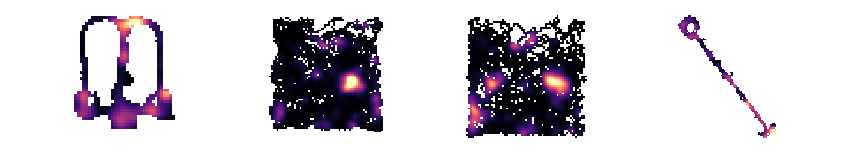

In [124]:
UID = 43
fig, axs = plt.subplots(1,4,figsize=functions.set_size("thesis", fraction=1.25, subplots=(1, 4)),edgecolor=None)
plt.subplots_adjust(wspace=-0.1, hspace=0)

uid_idx = np.where((cm.UID == UID).values)[0][0]

tc = maps.SpatialMap(pos[epochs[3]],st[epochs[3]],dim=2,tuning_curve_sigma=5)
ratemap_ = tc.tc.ratemap[uid_idx,:,:].copy()
ratemap_[tc.tc.occupancy == 0] = np.nan
sns.heatmap(ratemap_,cmap="magma",cbar=False,ax=axs[0],vmax=2,rasterized=True)
axs[0].axis("equal")
axs[0].axis("off")

tc = maps.SpatialMap(pos[epochs[7]],st[epochs[7]],dim=2,tuning_curve_sigma=5)
ratemap_ = tc.tc.ratemap[uid_idx,:,:].copy()
ratemap_[tc.tc.occupancy == 0] = np.nan
sns.heatmap(ratemap_,cmap="magma",cbar=False,ax=axs[1],vmax=5,rasterized=True)
axs[1].axis("equal")
axs[1].axis("off")

tc = maps.SpatialMap(pos[epochs[8]],st[epochs[8]],dim=2,tuning_curve_sigma=5)
ratemap_ = tc.tc.ratemap[uid_idx,:,:].copy()
ratemap_[tc.tc.occupancy == 0] = np.nan
sns.heatmap(ratemap_,cmap="magma",cbar=False,ax=axs[2],vmax=5,rasterized=True)
axs[2].axis("equal")
axs[2].axis("off")

tc = maps.SpatialMap(pos[epochs[9]][outbound_epochs],st[epochs[9]][outbound_epochs],dim=2,tuning_curve_sigma=5)
ratemap_ = tc.tc.ratemap[uid_idx,:,:].copy()
ratemap_[tc.tc.occupancy == 0] = np.nan
sns.heatmap(ratemap_,cmap="magma",cbar=False,ax=axs[3],vmax=2,rasterized=True)
axs[3].axis("equal")
axs[3].axis("off")

# sns.despine()
# tc = maps.SpatialMap(pos_linear,st[epochs[9]],dim=1,dir_epoch=inbound_epochs,tuning_curve_sigma=10)
# ratemap_ = tc.tc.ratemap[uid_idx,:].copy()
# ratemap_[tc.tc.occupancy == 0] = np.nan
# axs[3].plot(ratemap_)

plt.savefig(
    os.path.join(fig_save_path, "place_cell_example_kenji.svg"),
    dpi=600,
    bbox_inches="tight",
)

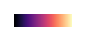

In [135]:
a = np.array([[0,1]])
plt.figure(figsize=(.5, .15))
img = plt.imshow(a, cmap="magma")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="horizontal", cax=cax)
plt.axis("off")
plt.savefig(os.path.join(fig_save_path,"magma_colorbar.svg"))

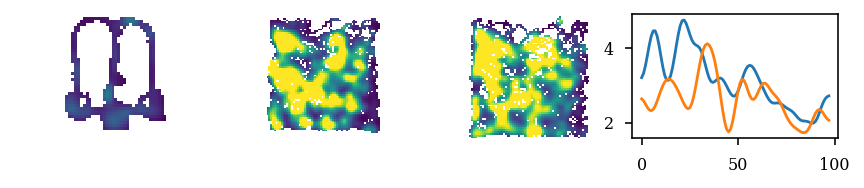

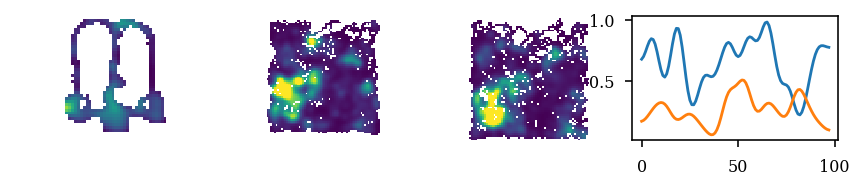

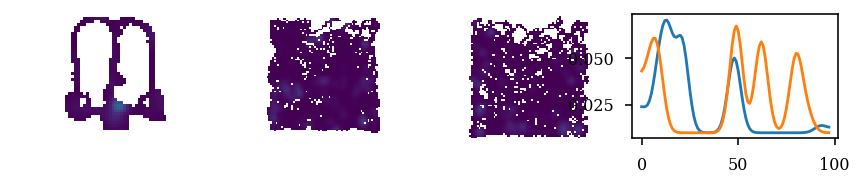

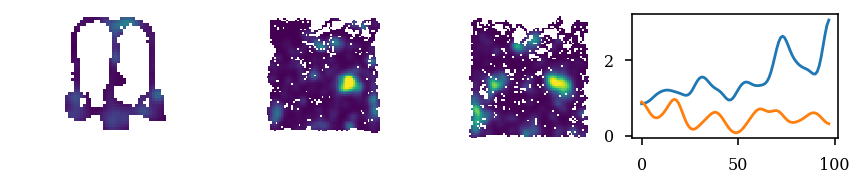

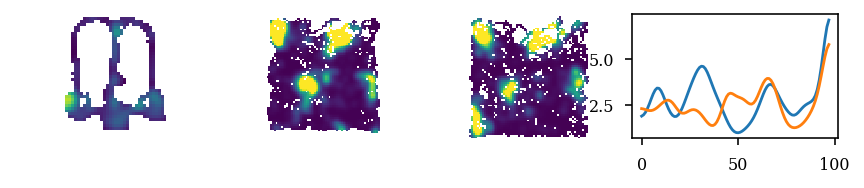

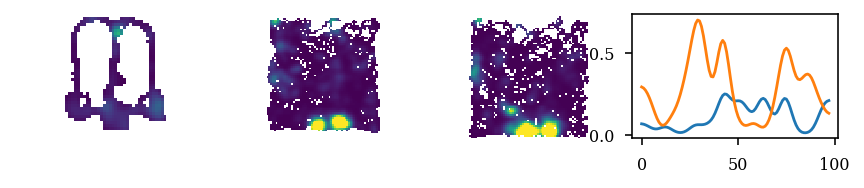

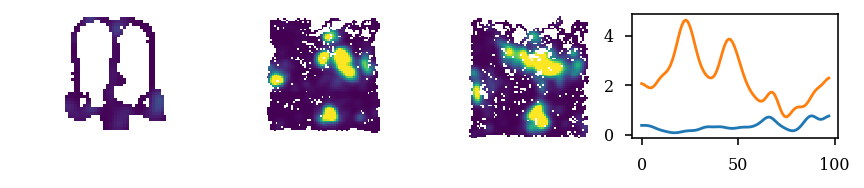

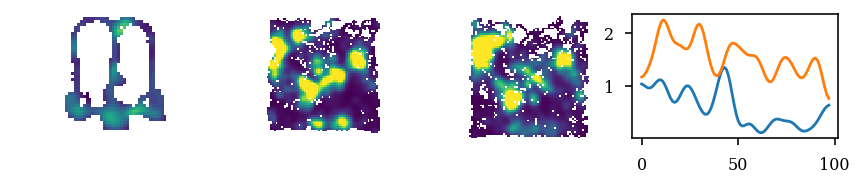

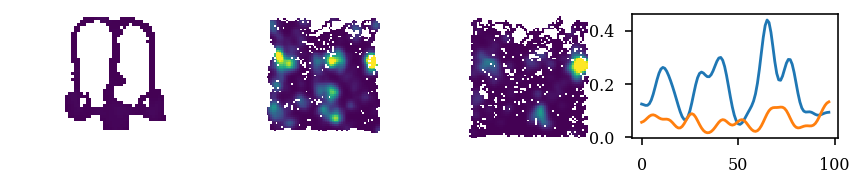

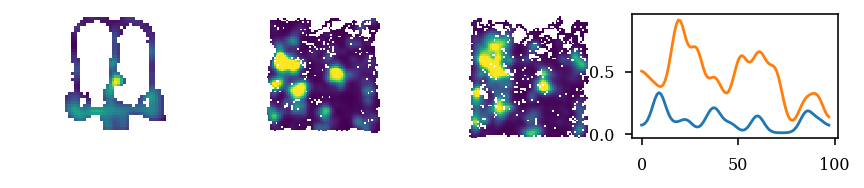

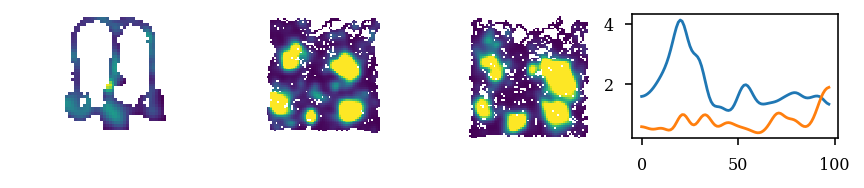

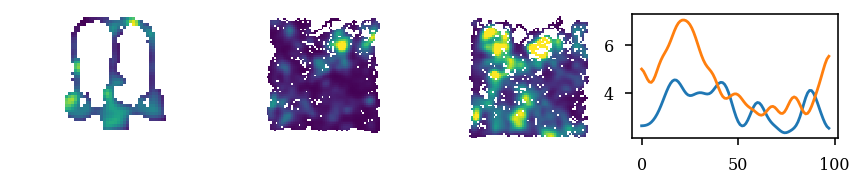

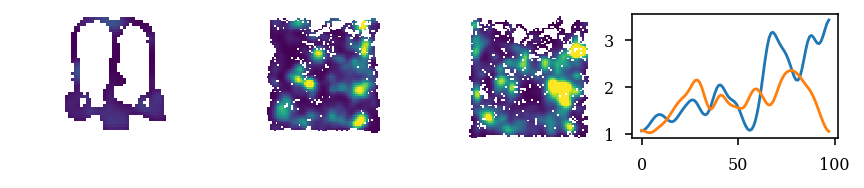

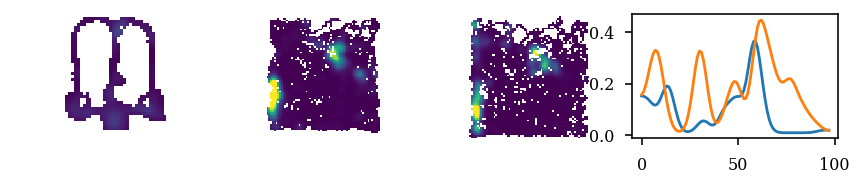

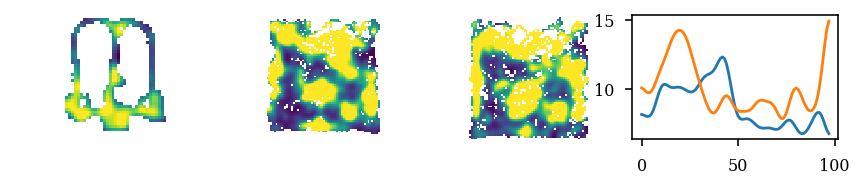

In [97]:
import logging

logging.getLogger().setLevel(logging.ERROR)

# UID = 43.0
# UID = 46 # grid cell 
# UID = 51 # maybe
for UID in cm.query("brainRegion.str.contains('CA1') & putativeCellType.str.contains('Pyr')").UID.values:
    fig, axs = plt.subplots(1,4,figsize=functions.set_size("thesis", fraction=1.25, subplots=(1, 4)),edgecolor=None)
    plt.subplots_adjust(wspace=0, hspace=0)

    uid_idx = np.where((cm.UID == UID).values)[0][0]

    tc = maps.SpatialMap(pos[epochs[3]],st[epochs[3]],dim=2,tuning_curve_sigma=5)
    ratemap_ = tc.tc.ratemap[uid_idx,:,:].copy()
    ratemap_[tc.tc.occupancy == 0] = np.nan
    sns.heatmap(ratemap_,cmap="viridis",cbar=False,ax=axs[0],vmax=5)
    axs[0].axis("equal")
    axs[0].axis("off")

    tc = maps.SpatialMap(pos[epochs[7]],st[epochs[7]],dim=2,tuning_curve_sigma=5)
    ratemap_ = tc.tc.ratemap[uid_idx,:,:].copy()
    ratemap_[tc.tc.occupancy == 0] = np.nan
    sns.heatmap(ratemap_,cmap="viridis",cbar=False,ax=axs[1],vmax=5)
    axs[1].axis("equal")
    axs[1].axis("off")

    tc = maps.SpatialMap(pos[epochs[8]],st[epochs[8]],dim=2,tuning_curve_sigma=5)
    ratemap_ = tc.tc.ratemap[uid_idx,:,:].copy()
    ratemap_[tc.tc.occupancy == 0] = np.nan
    sns.heatmap(ratemap_,cmap="viridis",cbar=False,ax=axs[2],vmax=5)
    axs[2].axis("equal")
    axs[2].axis("off")

    tc = maps.SpatialMap(pos_linear,st[epochs[9]],dim=1,dir_epoch=outbound_epochs,tuning_curve_sigma=10)
    ratemap_ = tc.tc.ratemap[uid_idx,:].copy()
    ratemap_[tc.tc.occupancy == 0] = np.nan
    axs[3].plot(ratemap_)

    tc = maps.SpatialMap(pos_linear,st[epochs[9]],dim=1,dir_epoch=inbound_epochs,tuning_curve_sigma=10)
    ratemap_ = tc.tc.ratemap[uid_idx,:].copy()
    ratemap_[tc.tc.occupancy == 0] = np.nan
    axs[3].plot(ratemap_)
    plt.show()

In [ ]:

UID = 43.0
# plot_place_cells(basepath, UID, save_path)
save_file = os.path.join(
    place_save_path, basepath.replace(os.sep, "_").replace(":", "_") + str(UID) + ".svg"
)
plt.savefig(save_file, dpi=300, bbox_inches="tight")